In [6]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import pickle
import shapely
from shapely.geometry import Point, box
from tqdm import tqdm

import global_gauges as gg

target_crs = "EPSG:4326"

save_dir = Path("/nas/cee-water/cjgleason/ted/swot-ml/data/reservoirs/")
metadata_dir = save_dir / "metadata" 
metadata_dir.mkdir(exist_ok=True)

In [ ]:
facade = gg.GaugeDataFacade(providers='usgs')
sites = facade.get_stations_n_days(90).to_crs(target_crs)

basin_sites = sites.clip(basin_geom).copy()
basin_sites.drop('provider_misc', axis=1, inplace=True) # all na column is problematic

In [ ]:
outlets = basin_sites[basin_sites['mean_discharge']>10].reset_index()
outlets = outlets.to_crs('epsg:4326')
outlets['lng'] = outlets.geometry.x
outlets['lat'] = outlets.geometry.y
outlets.rename(columns={'site_id':'id'}, inplace=True)

outlets['outlet_id'] = outlets.iloc[outlets['area'].argmax()]['id']
outlets = outlets.sort_values('area', ascending=False)

outlets = outlets[['id','lng','lat','area','name','outlet_id']]
outlets.to_csv('/nas/cee-water/cjgleason/ted/delineator/ohio_full.csv', index=False)

In [96]:
G[n]

AtlasView({})

{'area': 361.3,
 'reservoir': False,
 'shreve_order': 93,
 'strahler_order': 5,
 'custom': True,
 'length': 7.6,
 'total_area': 535722.7999999998,
 'dist_downstream': 0.0}

In [121]:
basin_name = "Ohio"
delineator_out = Path("/nas/cee-water/cjgleason/ted/delineator/output/")
subbasins = gpd.read_file(delineator_out / f"{basin_name}_subbasins.geojson")
rivers = gpd.read_file(delineator_out / f"{basin_name}_rivers.geojson")
outlets = gpd.read_file(delineator_out / f"{basin_name}_outlets.geojson")

with open(delineator_out / f"{basin_name}_graph.pkl", "rb") as f:
    G = pickle.load(f)


# Save into the modeling directory
for n, d in G.nodes(data=True):
    G.nodes[n]['area'] = float(d['area'])
    G.nodes[n]['reservoir'] = bool(d['reservoir'])
    G.nodes[n]['length'] = float(d['length'])
    G.nodes[n]['total_area'] = float(d['total_area'])
graph_json = nx.readwrite.json_graph.node_link_data(G, edges='edges')
with open(metadata_dir / f'{basin_name}_graph.json', 'w') as f:
    json.dump(graph_json, f, indent=4)

subbasins.to_file(metadata_dir / f'{basin_name}_basins.geojson')

print("Done!")

Done!


In [119]:
subbasins

,comid,unitarea,lat,lng,reservoir,nextdown,custom,area,name,outlet_id,is_outlet,reservoir_id,strahler_order,shreve_order,geometry,gauge_and_res,outlet
0,74024610,674.0,41.7700,-78.8742,False,USGS-03012550,False,NaN,None,None,None,None,1,7,"MULTIPOLYGON (((-78.87292 41.76875, -78.87292 ...",0,POINT (-78.8742 41.77)
1,74024620,715.2,41.9842,-78.6258,False,USGS-03011020,False,NaN,None,None,None,None,1,5,"POLYGON ((-78.59792 41.86125, -78.59708 41.861...",0,POINT (-78.6258 41.9842)
2,74024945,725.1,41.9758,-78.3933,False,USGS-03010820,False,NaN,None,None,None,None,1,3,"POLYGON ((-78.15292 41.88125, -78.15292 41.882...",0,POINT (-78.3933 41.9758)
3,74025163,892.1,42.1300,-79.1067,False,USGS-03015000,False,NaN,None,None,None,None,1,1,"POLYGON ((-79.20958 42.28458, -79.21125 42.284...",0,POINT (-79.1067 42.13)
4,74025192,500.4,42.1308,-79.1817,False,USGS-03015000,False,NaN,None,None,None,None,1,2,"POLYGON ((-79.15875 42.15042, -79.15792 42.150...",0,POINT (-79.1817 42.1308)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,USGS-03601990,926.8,35.7842,-87.4600,False,74058742,True,5304.269283,"DUCK RIVER AT HWY 100 AT CENTERVILLE, TN",outlet,False,None,1,9,"POLYGON ((-87.47708 35.52208, -87.47958 35.522...",10,POINT (-87.46 35.7842)
1053,USGS-03603000,372.2,35.9300,-87.7425,False,74058737,True,6622.566677,"DUCK RIVER ABOVE HURRICANE MILLS, TN",outlet,False,None,1,11,"POLYGON ((-87.74375 35.92292, -87.74375 35.926...",10,POINT (-87.7425 35.93)
1054,USGS-03604000,538.5,35.4958,-87.8333,False,USGS-03604400,True,1157.718930,"BUFFALO RIVER NEAR FLAT WOODS, TN",outlet,False,None,1,2,"POLYGON ((-87.80958 35.41458, -87.81042 35.414...",10,POINT (-87.8333 35.4958)
1055,USGS-03604400,718.4,35.8125,-87.7783,False,74058875,True,1818.162615,"BUFFALO RIVER BELOW LOBELVILLE, TN",outlet,False,None,1,3,"POLYGON ((-87.83625 35.72792, -87.83625 35.732...",10,POINT (-87.7783 35.8125)


<Axes: >

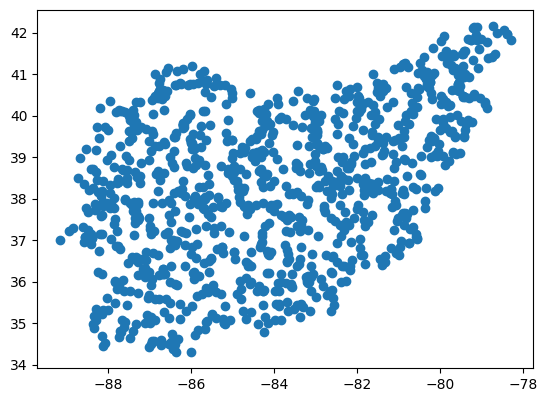

In [120]:



outlets.plot()

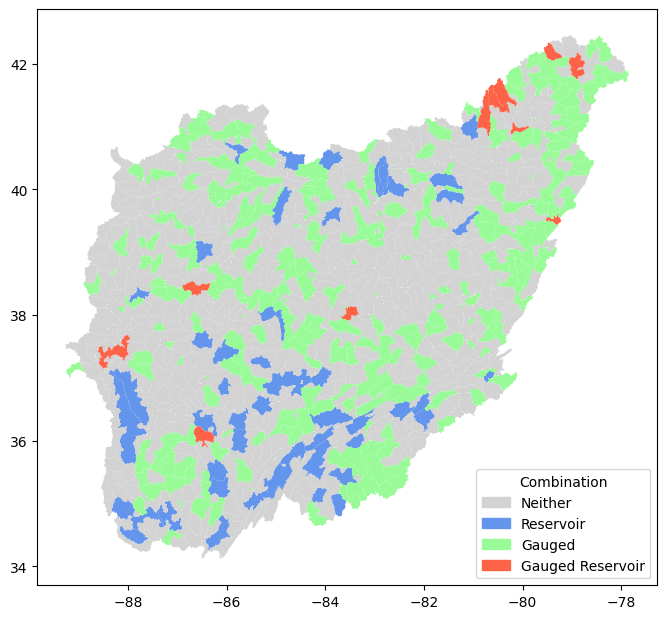

In [103]:
import matplotlib.patches as mpatches

plt.close('all')
fig, ax = plt.subplots(figsize=(8, 8))

subbasins['gauge_and_res'] = subbasins['custom'].astype(int)*10 + subbasins['reservoir'].astype(int)

color_map = {
    0: "lightgrey",
    1: "cornflowerblue",
    10: "palegreen",
    11: "tomato",
}
subbasins.plot(color=subbasins['gauge_and_res'].map(color_map), ax=ax)

label_map = {
    0: "Neither",
    1: "Reservoir",
    10: "Gauged",
    11: "Gauged Reservoir",
}
patches = [mpatches.Patch(color=color_map[i], label=label_map[i]) for i in color_map]
ax.legend(handles=patches, title="Combination", loc='lower right')
plt.show()

In [40]:
# Analyze basic graph structure
def graph_stats(G):
    """Quick graph analysis"""
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges: {G.number_of_edges()}")
    
    # Find sources and sinks
    sources = [n for n in G.nodes() if G.in_degree(n) == 0]
    sinks = [n for n in G.nodes() if G.out_degree(n) == 0]
    print(f"Sources (headwaters): {len(sources)}")
    print(f"Sinks (outlets): {len(sinks)}")
    
    # Stats
    areas = []
    reservoir_count = 0
    gauge_count = 0
    for _, data in G.nodes(data=True):
        areas.append(data['area'])
        reservoir_count += int(data.get('reservoir')==True)
        gauge_count += int(data.get('custom')==True)
        
    mean_area = np.mean(areas)

    print(f"{reservoir_count = }")
    print(f"{gauge_count = }")
    print(f"{mean_area = :.2f}")
    

graph_stats(G)

Nodes: 1057
Edges: 1056
Sources (headwaters): 288
Sinks (outlets): 1
reservoir_count = 32
gauge_count = 346
mean_area = 506.83


<Axes: >

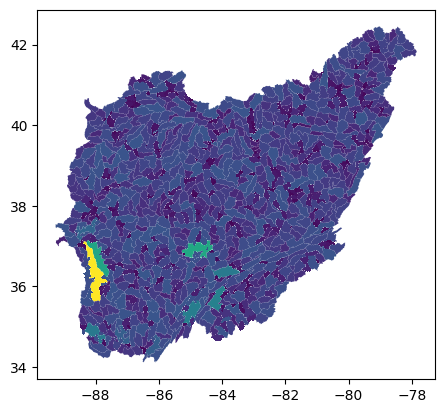

In [104]:
subbasins.plot('unitarea')

<Axes: >

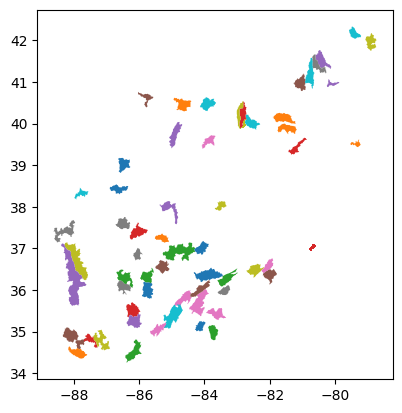

In [105]:
subbasins.plot('reservoir_id')